In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
sys.path.append(".")
sys.path.append("./utils")
from custom_lbfgs import *
from SSAutil import *
from neuralnetwork import NeuralNetwork, MinmaxScaleLayer, UpScaleLayer
from SSA_equations.SSANN import SSANN_calvingfront_invertC
from logger import Logger
from plotting import *
import matplotlib.pyplot as plt

In [2]:
# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# Hyper parameters {{{
hp = {}
# Data size on the solution u
hp["N_u"] = 3000
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 500
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 5]
#hp["C_layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 100000
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 50000
hp["nt_lr"] = 0.8
hp["nt_ncorr"] = 50
hp["log_frequency"] = 1000
hp["use_tfp"] = True
# Record the history
hp["save_history"] = True
hp["history_frequency"] = 10
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
# path = os.path.join(appDataPath, "SSA2D_nocalving.mat")
# path = os.path.join(appDataPath, "SSA2D_seg_nocalving.mat")
path = os.path.join(appDataPath, "SSA2D_segCF.mat")
modelPath = "./Models/test"
reloadModel = False # reload from previous training
#}}}

In [3]:
# load the data
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb = prep_Helheim_data_all(path, hp["N_u"], hp["N_f"])

# Creating the model and training
logger = Logger(hp)
pinn = SSANN_calvingfront_invertC(hp, logger, X_f, 
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb, 
        modelPath, reloadModel,
        mu=1.1060e8,
        loss_weights=[1e-2, 1e-2, 1e-2, 1e-4, 1e-8])

X_u = pinn.tensor(X_star)
u = pinn.tensor(u_star)
# error function for logger
def error():
    return pinn.test_error(X_u, u)
logger.set_error_fn(error)

Hyperparameters:
{
  "N_u": 3000,
  "N_f": 500,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    5
  ],
  "tf_epochs": 100000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 50000,
  "nt_lr": 0.8,
  "nt_ncorr": 50,
  "log_frequency": 1000,
  "use_tfp": true,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# train the model
pinn.fit(X_u_train, u_train)

# save
#pinn.model.save("./Models/SSA2D_friction_1e_4_TF"+str(hp["tf_epochs"]) +"_NT"+str(hp["nt_epochs"]))


Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:18 (+18.1)  loss = 3.7049e+10  
tf_epoch =   1000  elapsed = 00:44 (+26.4)  loss = 1.4250e+05  
tf_epoch =   2000  elapsed = 01:10 (+26.4)  loss = 1.1956e+05  
tf_epoch =   3000  elapsed = 01:37 (+26.4)  loss = 9.8429e+04  
tf_epoch =   4000  elapsed = 02:03 (+26.3)  loss = 7.7628e+04  
tf_epoch =   5000  elapsed = 02:30 (+26.3)  loss = 6.0518e+04  
tf_epoch =   6000  elapsed = 02:56 (+26.3)  loss = 4.6163e+04  
tf_epoch =   7000  elapsed = 03:22 (+26.3)  loss = 3.5656e+04  
tf_epoch =   8000  elapsed = 03:49 (+26.3)  loss = 2.8708e+04  
tf_epoch =   9000  elapsed = 04:15 (+26.3)  loss = 2.6543e+04  
tf_epoch =  10000  elapsed = 04:41 (+26.3)  loss = 2.5195e+04  
tf_epoch =  11000  elapsed = 05:08 (+26.3)  loss = 2.4246e+04  
tf_epoch =  12000  elapsed = 05:34 (+26.3)  loss = 2.3411e+04  
tf_epoch =  13000  elapsed = 06:01 (+26.3)  loss = 2.2528e+04  
tf_epoch =  14000  elapsed = 06:27 (+26.3)  loss = 2.

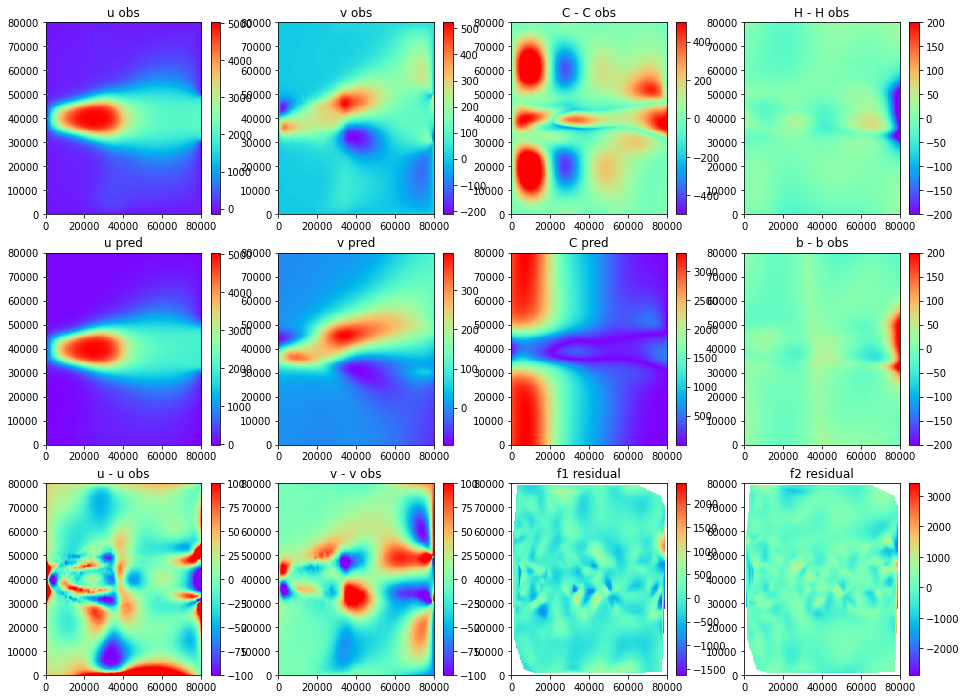

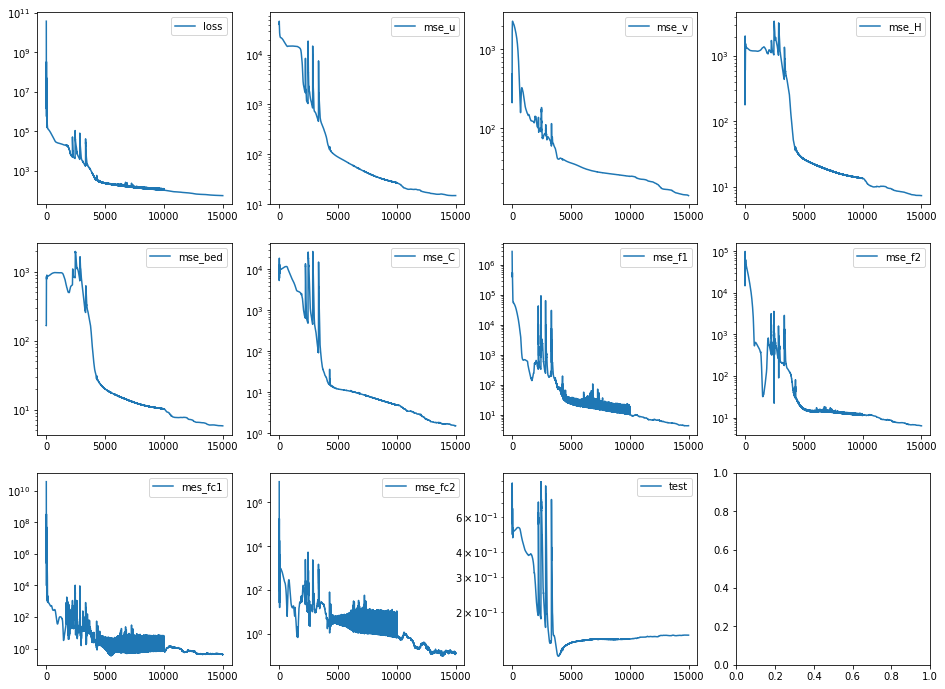

In [14]:
# plot
vranges = {}
vranges['u - u obs']=[-100, 100]
vranges['v - v obs']=[-100, 100]
vranges['H - H obs']=[-200, 200]
vranges['b - b obs']=[-200, 200]
vranges['C - C obs']=[-500, 500]
plot_Helheim_all(pinn, X_f, X_star, u_star, xlb, xub, vranges)

# history
plot_log_history(pinn)